# Amplitude Modulation

## OOK Signal

In [1]:
# imports
import numpy as np


from commstools import set_backend
from commstools.plotting import plot_ideal_constellation
from commstools.waveforms import pam_waveform, rzpam_waveform

set_backend("gpu")


The On-Off Keying (OOK) signal is a simple amplitude modulation scheme where the carrier is present (high) when the bit is 1 and absent (low) when the bit is 0.

The constellation representation:

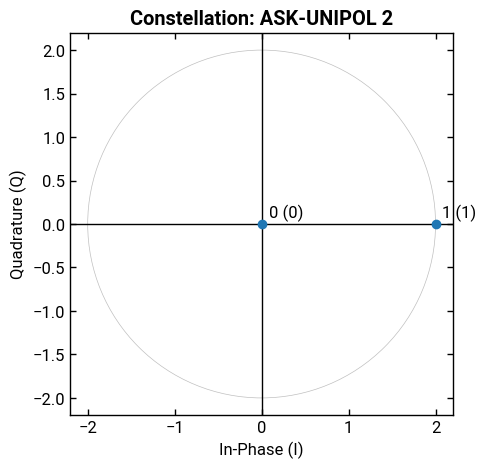

In [2]:
plot_ideal_constellation(modulation="ask-unipol", order=2, show=True)


### RZ Scheme

Let's generate a waveform for so-called Return-to-Zero (RZ) encoding:

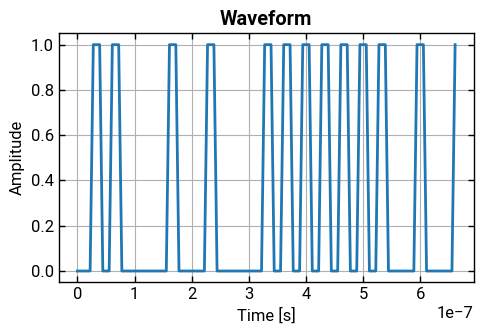

In [22]:
symbol_rate = 30e6
sampling_rate = 200e6
sps = int(sampling_rate / symbol_rate)

ook_rz_rect = rzpam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rect",
    seed=42,
)
ook_rz_rect.plot_symbols(num_symbols=20, show=True)


Now the pulses represent perfect rectangles, which is not possible to generate with realistic equipment.

Also, such a waveform has very wide spectrum:

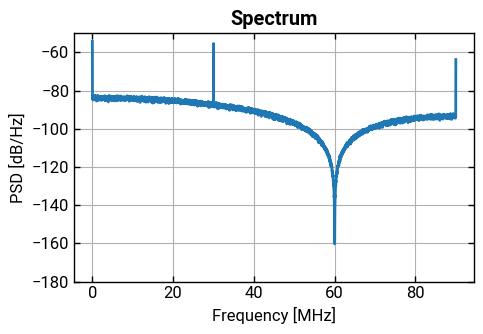

In [23]:
ook_rz_rect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


To make waveform more practically realizable, we can pulse shape it to be gaussian-smoothed rectangular.

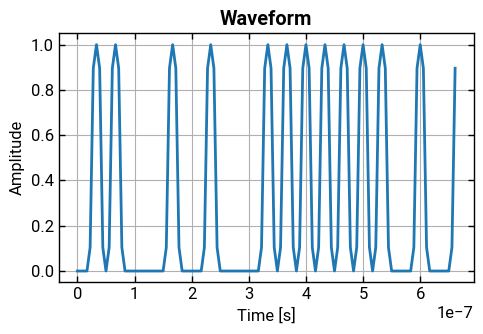

In [5]:
ook_rz_smoothrect = rzpam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="smoothrect",
    seed=42,
)
ook_rz_smoothrect.plot_symbols(num_symbols=20, show=True)


In this case, energy in the sidelobes is suppresed more:

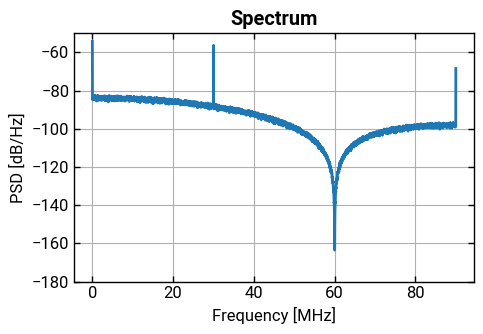

In [6]:
ook_rz_smoothrect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


We also note that for RZ encoding, in the spectrum we have a strong tone at the symbol rate (repetition rate in this case) and its integer multiplies.
This is a useful property, called Self-Clocking, which lets receiver to lock onto this clock.

Let's look at the eye diagrams for this signal (preliminary adding some random noise for more realistic eye)

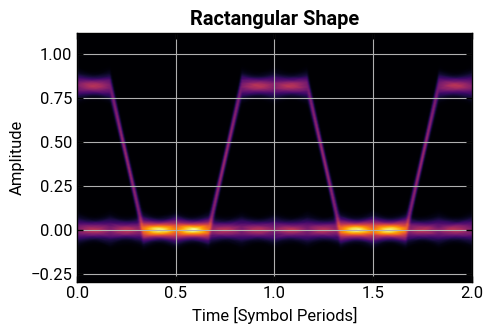

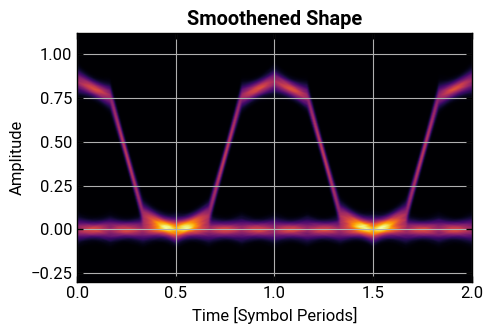

In [7]:
from commstools.channel import add_gaussian_noise

ook_rz_rect_n = add_gaussian_noise(ook_rz_rect, snr_db=20)
ook_rz_smoothrect_n = add_gaussian_noise(ook_rz_smoothrect, snr_db=20)

ook_rz_rect_n.plot_eye(title="Ractangular Shape", show=True)
ook_rz_smoothrect_n.plot_eye(title="Smoothened Shape", show=True)


### NRZ Scheme

The other encoding used with OOK is Non-Return-to-Zero (NRZ) - which requires half the bandwidth of RZ and is superior if system has bandwidth limitations.

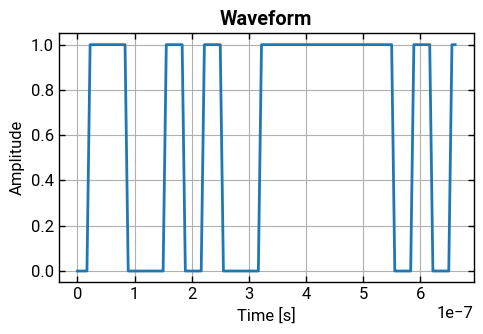

In [26]:
ook_nrz_rect = pam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rect",
    seed=42,
)
ook_nrz_rect.plot_symbols(num_symbols=20, show=True)


The spectrum is narrower, but doesn't contain the clock tone:

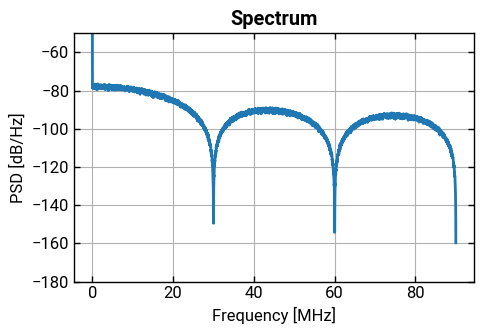

In [27]:
ook_nrz_rect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


Let's also smooth the rect pulse.

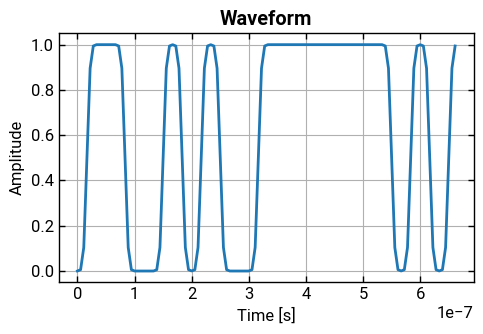

In [10]:
ook_nrz_smoothrect = pam_waveform(
    order=2,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="smoothrect",
    seed=42,
)
ook_nrz_smoothrect.plot_symbols(num_symbols=20, show=True)


And see sidelobe energy reduction in the spectrum:

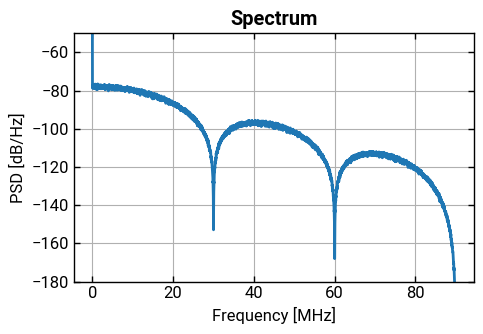

In [11]:
ook_nrz_smoothrect.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))


Eye diagrams:

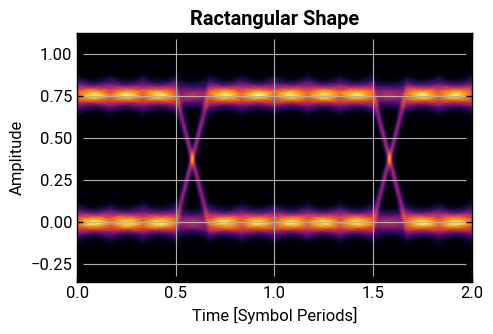

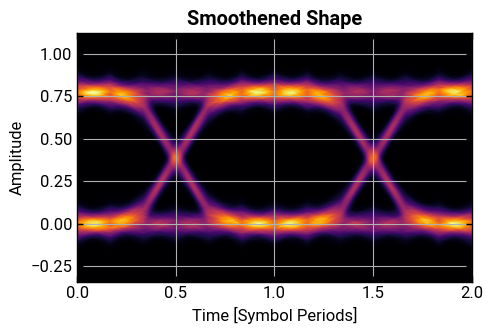

In [ ]:
ook_nrz_rect_n = add_gaussian_noise(ook_nrz_rect, snr_db=20)
ook_nrz_smoothrect_n = add_gaussian_noise(ook_nrz_smoothrect, snr_db=20)

ook_nrz_rect_n.plot_eye(title="Ractangular Shape", show=True)
ook_nrz_smoothrect_n.plot_eye(title="Smoothened Shape", show=True)


## PAM Signal

Pulse-amplitude modulation (PAM) uses same concept, but usually assumed to be NRZ encoded and utilize multiple amplitude levels to represent more bits per symbolslot.
For instance, PAM-4 maps each amplitude level to 2 bits:

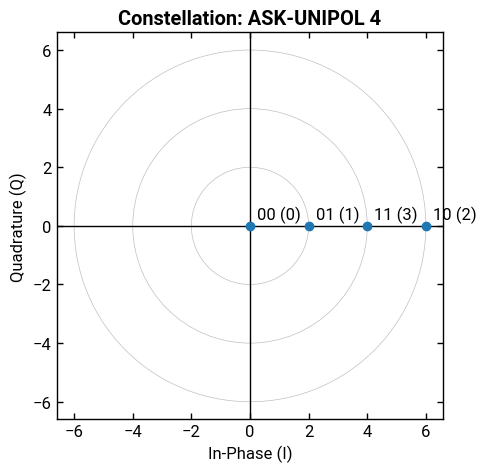

In [ ]:
plot_ideal_constellation(modulation="ask-unipol", order=4, show=True)


Let's demonstrate this format using rrc pulse shape.

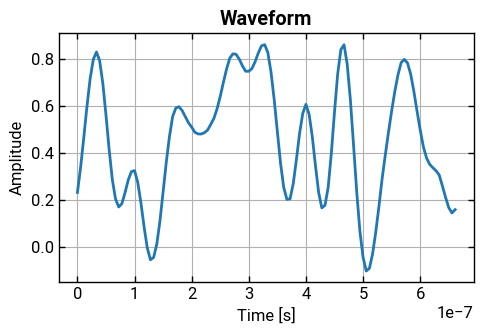

In [ ]:
pam4 = pam_waveform(
    order=4,
    bipolar=False,
    num_symbols=100_000,
    sps=sps,
    symbol_rate=symbol_rate,
    pulse_shape="rrc",
    seed=42,
)

pam4.plot_symbols(num_symbols=20, show=True)


The bandwidth of rrc-shaped signal is near-nyquist (relative to symbol rate) with some excess bandwidth from roll-off factor.

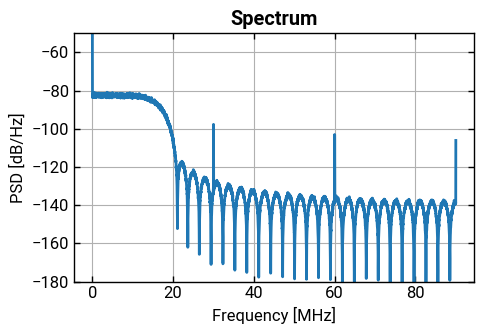

In [ ]:
pam4.plot_psd(show=True, nperseg=2**14, ylim=(-180, -50))
